In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
import math


### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

-0.01084098704 0.02815552265 0.00039265133851975654
-0.01084098704 0.02815552265 0.00039265133851975654


Text(0.5, 1.0, 'Original matrix')

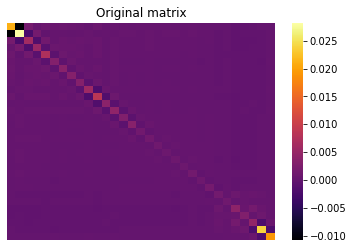

In [2]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))

# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)

# scaler_sys = StandardScaler()
# scaler_sys.fit(syscov)
# syscov_sc = scaler_sys.transform(syscov)

print(np.min(syscov), np.max(syscov), np.mean(syscov))
sns.heatmap(pd.DataFrame(syscov), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix')

In [3]:
scalercov = StandardScaler()
scalercov.fit(syscov)
syscov_sc = scalercov.transform(syscov)


In [4]:
# syscov_triang = np.triu(syscov)

        

# sns.heatmap(scaler_sys.inverse_transform(syscov_triang), 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True,
#         robust=False)

In [5]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
#         p = symmetrical(p)
        matrixset[it, :, :] = p
    return matrixset


In [6]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
    #         if np.iscomplex(syscov[i,j]):
    #             print("COMPLEX")
            if matrix[i,j] != matrix[j,i]:
                    if np.abs(matrix[i, j]) < np.abs(matrix[j,i]):
                        matrix[i, j] = matrix[j, i]
                    else:
                        matrix[j, i] = matrix[i, j]
            
    return matrix

In [7]:

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

### Generate a data set with covariance matrix from the original plus gaussian noise

In [8]:
magnitudes = matrixMag(syscov_sc)

In [9]:
numMatrix = 5000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))
permMatrix = permutMatrix(syscov_sc, numMatrix)
print(np.shape(permMatrix))

(5000, 31, 31)


Text(0.5, 1.0, 'PERMUTATED MATRIX')

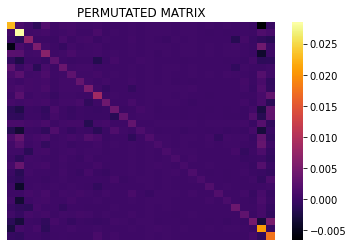

In [10]:
# sns.heatmap(pd.DataFrame(permMatrix[99, :, : ]), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX")

In [11]:
# syscov_sc

In [12]:


for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.rand()
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                covset[i, row, col] = permMatrix[i, row, col] + 1e-4*err*10**magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col] + 1e-4*10**err*magnitudes[row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] + 0.00001*err*10**magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col]  + 0.001*err*10**magnitudes[row, col]
#                 filled_matrix[row, col] = 0.1*np.random.rand()*10**magnitudes[row, col]


            
#     covset[i,:,:] = scalercov.transform(covset[i,:,:])
#     covset_noise[i,:,:] = scalercov.transform(covset_noise[i,:,:])
            

# covset = scalercov.transform(covset)
# covset_noise = scalercov.transform(covset_noise)

 Generating 5000 matrix      

In [13]:
# sns.heatmap(pd.DataFrame(covset_log[100]), 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True)

In [14]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

(5000, 31, 31)


Text(0.5, 1.0, 'NOISE MATRIX')

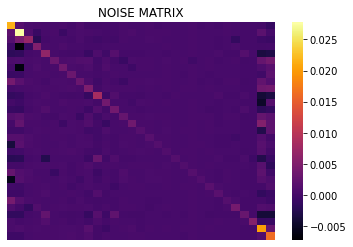

In [15]:
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(covset_noise_test[0])), 
# sns.heatmap(pd.DataFrame(covset_noise_test[100]), 
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("NOISE MATRIX")

Text(0.5, 1.0, 'TEST MATRIX')

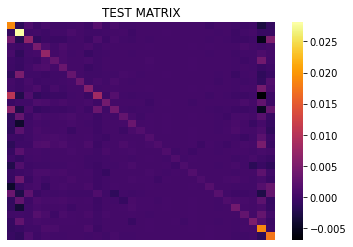

In [16]:
sns.heatmap(pd.DataFrame(scalercov.inverse_transform(covset_test[10])), 
# sns.heatmap(pd.DataFrame(np.exp(covset_test[100])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")
# np.exp(covset_test[0])

In [17]:
input_img = tf.keras.Input(shape=(31, 31, 1))

x = layers.ZeroPadding2D(((5,4),(5,4)))(input_img)
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
decoded = layers.Cropping2D(cropping=((5, 4), (5, 4)))(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 31, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 4)         292   

In [18]:
autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=100,
                batch_size=512,
                            
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))

Epoch 1/100
8/8 [==============================] - 7s 791ms/step - loss: 1.0023 - val_loss: 0.9811
Epoch 2/100
8/8 [==============================] - 6s 758ms/step - loss: 0.9739 - val_loss: 0.9430
Epoch 3/100
8/8 [==============================] - 6s 752ms/step - loss: 0.9281 - val_loss: 0.8902
Epoch 4/100
8/8 [==============================] - 6s 756ms/step - loss: 0.8799 - val_loss: 0.8486
Epoch 5/100
8/8 [==============================] - 6s 755ms/step - loss: 0.8379 - val_loss: 0.8053
Epoch 6/100
8/8 [==============================] - 6s 753ms/step - loss: 0.7930 - val_loss: 0.7522
Epoch 7/100
8/8 [==============================] - 6s 752ms/step - loss: 0.7353 - val_loss: 0.6810
Epoch 8/100
8/8 [==============================] - 6s 750ms/step - loss: 0.6607 - val_loss: 0.6044
Epoch 9/100
8/8 [==============================] - 6s 753ms/step - loss: 0.5856 - val_loss: 0.5383
Epoch 10/100
8/8 [==============================] - 6s 752ms/step - loss: 0.5234 - val_loss: 0.4823
Epoch 11/

8/8 [==============================] - 6s 731ms/step - loss: 0.2308 - val_loss: 0.2379
Epoch 84/100
8/8 [==============================] - 6s 715ms/step - loss: 0.2365 - val_loss: 0.2343
Epoch 85/100
8/8 [==============================] - 6s 721ms/step - loss: 0.2319 - val_loss: 0.2310
Epoch 86/100
8/8 [==============================] - 6s 728ms/step - loss: 0.2299 - val_loss: 0.2311
Epoch 87/100
8/8 [==============================] - 6s 728ms/step - loss: 0.2298 - val_loss: 0.2291
Epoch 88/100
8/8 [==============================] - 6s 743ms/step - loss: 0.2295 - val_loss: 0.2372
Epoch 89/100
8/8 [==============================] - 6s 752ms/step - loss: 0.2373 - val_loss: 0.2351
Epoch 90/100
8/8 [==============================] - 6s 745ms/step - loss: 0.2323 - val_loss: 0.2291
Epoch 91/100
8/8 [==============================] - 6s 733ms/step - loss: 0.2295 - val_loss: 0.2287
Epoch 92/100
8/8 [==============================] - 6s 730ms/step - loss: 0.2290 - val_loss: 0.2283
Epoch 93/100


(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

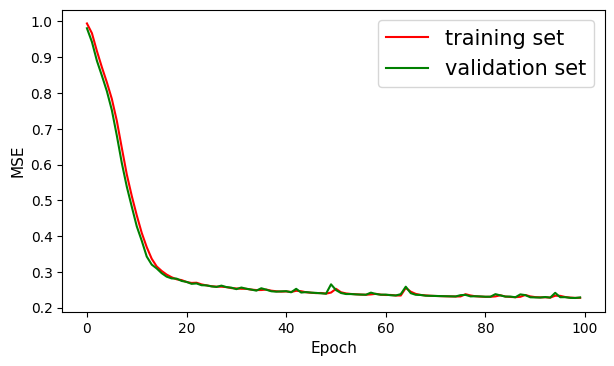

In [19]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [20]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

0.22709468007087708 0.22739370167255402


In [21]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

In [22]:
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True,
#         robust=False)
# plt.title('Test noise matrix')
np.shape(np.mean(covset_noise_test, axis=0)), np.shape(covset_noise_test[0])

((31, 31), (31, 31))

(1000, 31, 31)
(1, 31, 31, 1)
(31, 31)


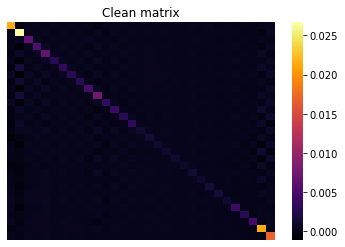

In [23]:
print(np.shape(covset_noise_test))
clean_img = autoencoder.predict(covset_noise_test[0,:,:].reshape(1,31,31))

print(np.shape(clean_img))
# clean_imgr = np.exp(clean_img.reshape(31,31))
clean_imgr = scalercov.inverse_transform(clean_img.reshape(31,31))
# clean_imgr = symmetrical(clean_imgr)
print(np.shape(clean_imgr))

# clean_imgr = symmetrical(clean_imgr)
sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Clean matrix')

np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")
# scaler_sys.inverse_transform(clean_img.reshape(31,31))

Text(0.5, 1.0, 'Filled matrix')

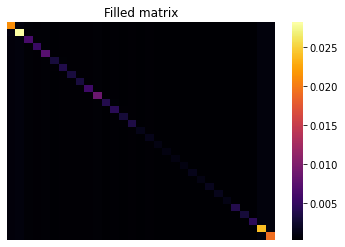

In [52]:
filled_matrix = np.zeros((nsize, nsize))
# err = np.random.randn()
for row in range(nsize):
    for col in range(nsize):
        if row == col:
#             err = np.random.randn()
            filled_matrix[row, col] = syscov_sc[row, col] 
#     + 0.1*err*magnitudes[row, col]
        else:
            filled_matrix[row, col] = 0.1*np.random.rand()*10**magnitudes[row, col] # this work with original syscov
#             filled_matrix[row, col] = 0.001*np.random.rand()

filled_matrix = scalercov.inverse_transform(filled_matrix)
# filled_matrix = symmetrical(filled_matrix)

sns.heatmap(pd.DataFrame(filled_matrix), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Filled matrix')


Text(0.5, 1.0, 'Reconstructed matrix with conv-AE')

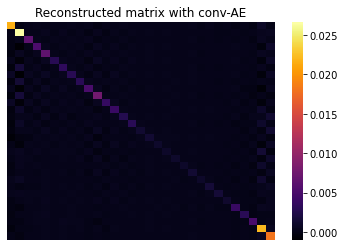

In [53]:
filled_matrix = scalercov.transform(filled_matrix).reshape(1,31,31,1)
# filled_matrix = filled_matrix.reshape(1,31,31,1)

clean_img = autoencoder.predict(filled_matrix)

clean_imgr = scalercov.inverse_transform(clean_img[0,:,:,0].reshape(31,31))
# clean_imgr = clean_img[0,:,:,0].reshape(31,31)

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Reconstructed matrix with conv-AE')
# plt.savefig('rec_matrix_conv_ae.png')

In [54]:
# clean_imgr = symmetrical(clean_imgr)

In [55]:
np.savetxt("fake_binned_JLA_COVdecodedTEST2.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

In [29]:
autoencoder.save('../models/autoencoderCONV_JLA.h5')
# decoder.save('../models/decoderJLA.h5')
# encoder.save('../models/encoderJLA.h5')

In [ ]:
# sns.heatmap(pd.DataFrame(clean_imgr), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', 
#             robust=False)